In [1]:
import numpy as np
import gwpy 
from gwpy.timeseries import TimeSeries
import bilby
import matplotlib.pyplot as plt
%matplotlib inline


# Plotting the GW strain
We'll first plot the strain data from GW170817 as a sanity check. 
The trigger time represents the "time" of the event.  We want to make 
sure we're using the right data.  When the next cell runs, you should be able to faintly 
see the chirp of GW170817 in the q-scan.  

*Note*:
There was a very large glitch that occured on top of GW170817. It has been subtracted in released data.  If it were in the data,  it would be obvious as a region of time-frequency space with a ridiculous amount of strain power

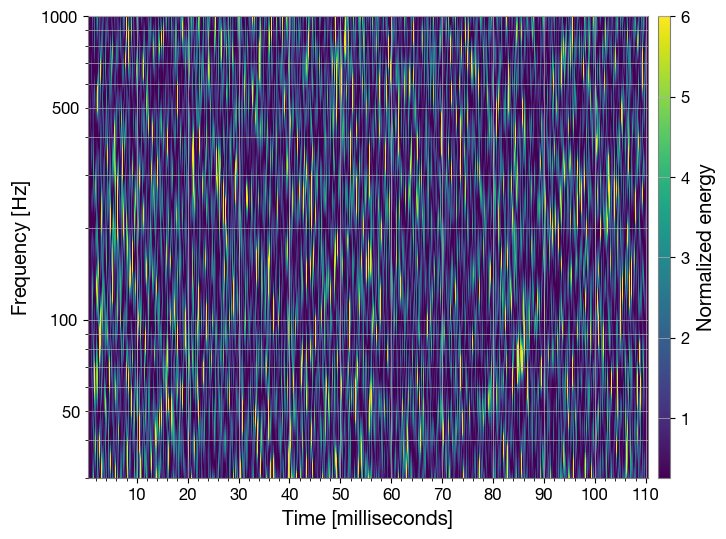

<Figure size 640x480 with 0 Axes>

In [8]:

trigger_time=1187008882.43
gps = trigger_time
detector="L1"
#"L1:DCH-CLEAN_STRAIN_C02_T1700406_v3" one without glitch
data = TimeSeries.read(source=f"./{detector}_170817_data.gwf", channel=f"{detector}:LOSC-STRAIN", 
                       start=trigger_time-90, end=trigger_time+20)

qspecgram = data.q_transform(qrange=(4,64))


plot = qspecgram.plot(vmin=.25, vmax=6, figsize=[8, 6])

ax = plot.gca()
#plt.axvline(90, color="red")
ax.set_yscale('log')
ax.set_xlabel('Time [milliseconds]')
ax.set_ylim(30, 1000)
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plt.show()
plt.savefig(f"{detector}_spectrogram_normalized.png")

# Running parameter estimation
The LVK uses multiple bayesian inference libraries for performing parameter estimation on signals.  One of the most popular and user friendly codes is *bilby*.  Here we will perform bayesian parameter estimation on the strain data from GW 190425.  This tutorial is copied from  [the bilby 190425 tutorial](https://git.ligo.org/lscsoft/bilby/-/blob/master/examples/gw_examples/data_examples/GW190425.py).  Also please check
out the [bilby docs](https://lscsoft.docs.ligo.org/bilby/index.html) if you're interested. 

## What's going on here? 
In general sampling algorithms have to be used in order to effectively compute the posterior distributions on parameters from Compact Binary Coalescences (CBCs).  The target, however, is usually to compute 
$P(\theta|d)$, where $\theta$ are the parameters and $d$ represents gravitational wave data.  It is not clear what this probability means, in a Bayesian sense it can be effectively defined as
$$P(\theta|d) = \frac{P(d|\theta) P(\theta)}{P(d)}.$$
$P(d|\theta)$ is simple to interpret probabilistically: it is the probability of getting the data stream $d$ in the detector given a CBC with parameters $\theta$ has occured. The only randomness is therefore due to the noise, which is (mostly) well understood.  $P(d|\theta)$ is often called the likelihood of the data given the parameters, it is labeled $\cal L(d|\theta)$ to avoid symbol duplication, and can be computed given only knowledge of the physical system and the underlying sensitvity of the detector.  It is a function of $\theta$, and so may from time to time be confusingly written $\cal L_d(\theta)$. The (log) likelihood for gravitational wave signals is given by (see [here](https://arxiv.org/pdf/1908.11170.pdf))
$$\log \cal L (d|\theta) =  -\frac{1}{2}\left(d-h(\theta)|d-h(\theta)\right) + \log\cal L_0.$$  Where $h(\theta)$ is the predicted strain in the detector from parameters $\theta$, $\log \cal L_0$ is a constant (independent of $\theta$), and $$(a|b) = \int \frac{a^*b + b^*a}{S_n(f)}df $$ is the *noise-weighted inner product with respect to PSD* $S_n(f)$.  Evaluating the likelihood is by far the most expensive component of GW analysis.  The reason gravitational waves carry information about the nuclear equation of state, is because both tidal deformabilities $\Lambda$ and  source masses $m$ appear in the likelihood for binary neutron stars, although typically in a alternative parameterization of $\cal M_c$ and $\tilde \Lambda$ for example. 

$P(\theta)$ is called the prior on the parameters, and is often written as $\pi(\theta)$.  Unlike the likelihood, the prior cannot be computed from first principles, it must be chosen.  For CBCs, usually choosing the prior is straightforward (though in certain cases there can be subtelties, especially when spins are involved). 

$P(d)$ is called the evidence, and is often notated as $\cal Z_d$, this is the probability of the data *under the assumption* that the data stream contains a signal from a CBC.  It is also called the marginal likelihood, because it can be computed as $$\cal Z_d = \int \cal L(d|\theta) \pi(\theta)d\theta.$$  The assumption that the source came from a CBC is usually supressed in notation but always present in parameter estimation.  For this reason parameter estimation is not itself a test of the astrophysicality of a signal.  If an alternative hypothesis were allowed, i.e. that the data is completely explained by noise, then the evidence for each hypothesis could be computed, and a Bayes factor would be given by $$\cal B  = \frac{\cal Z_d(\text{Signal})}{\cal Z_d(\text{noise})}$$


In [ ]:
logger = bilby.core.utils.logger
outdir = "outdir_190425"
label = "GW190425"

# Note you can get trigger times using the gwosc package, e.g.
# > from gwosc import datasets
# > datasets.event_gps("GW190425")
trigger_time = 1240215503.0
detectors = ["L1", "V1"]
maximum_frequency = 512
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 128  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

# The fiducial parameters are taken to me the max likelihood sample from the
# posterior sample release of LIGO-Virgo
# https://www.gw-openscience.org/eventapi/html/O3_Discovery_Papers/GW190425/
# The fiducial parameters should always be in provided in the same basis as
# the sampling basis. For example, if sampling in  `mass_1` and `mass_2` instead of
# `chirp_mass` and `mass_ratio`, the fiducial parameters should also be provided in
# `mass_1` and `mass_2` below.

fiducial_parameters = {
    "a_1": 0.018,
    "a_2": 0.016,
    "chirp_mass": 1.48658,
    "dec": 0.438,
    "geocent_time": 1240215503.039,
    "lambda_1": 446.941,
    "lambda_2": 43.386,
    "luminosity_distance": 206.751,
    "mass_ratio": 0.8955,
    "phase": 3.0136566567608765,
    "phi_12": 4.319,
    "phi_jl": 5.07,
    "psi": 0.281,
    "ra": 4.2,
    "theta_jn": 0.185,
    "tilt_1": 0.879,
    "tilt_2": 0.514,
}
psd_duration = 1024
psd_start_time = start_time - psd_duration
psd_end_time = start_time

# We now use gwpy to obtain analysis and psd data and create the ifo_list
ifo_list = bilby.gw.detector.InterferometerList([])
for det in detectors:
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    # This step is where gwpy accesses the open data
    data = TimeSeries.fetch_open_data(det, start_time, end_time)
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

logger.info("Saving data plots to {}".format(outdir))
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

# We now define the prior.
# We have defined our prior distribution in a local file, GW190425.prior
# The prior is printed to the terminal at run-time.
# You can overwrite this using the syntax below in the file,
# or choose a fixed value by just providing a float value as the prior.
priors = bilby.gw.prior.BBHPriorDict(filename="GW190425.prior")
priors["fiducial"] = 0

# Add the geocent time prior
priors["geocent_time"] = bilby.core.prior.Uniform(
    trigger_time - 0.1, trigger_time + 0.1, name="geocent_time"
)

# In this step we define a `waveform_generator`. This is the object which
# creates the frequency-domain strain. In this instance, we are using the
# `lal_binary_black_hole model` source model. We also pass other parameters:
# the waveform approximant and reference frequency and a parameter conversion
# which allows us to sample in chirp mass and ratio rather than component mass
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star_relative_binning,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments={
        "waveform_approximant": "IMRPhenomPv2_NRTidalv2",
        "reference_frequency": 20,
    },
)

# In this step, we define the likelihood. Here we use the standard likelihood
# function, passing it the data and the waveform generator.
# Note, phase_marginalization is formally invalid with a precessing waveform such as IMRPhenomPv2 
# (but we use it anyway because precession is small )

likelihood = bilby.gw.likelihood.RelativeBinningGravitationalWaveTransient(
    ifo_list,
    waveform_generator,
    priors=priors,
    time_marginalization=False,
    phase_marginalization=True,
    distance_marginalization=True,
    fiducial_parameters=fiducial_parameters,
)

# Finally, we run the sampler. This function takes the likelihood and prior
# along with some options for how to do the sampling and how to save the data
result = bilby.run_sampler(
    likelihood,
    priors,
    sampler="dynesty",
    outdir=outdir,
    label=label,
    nlive=1000,
    check_point_delta_t=600,
    check_point_plot=True,
    npool=1,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
)
result.plot_corner()


21:18 bilby INFO    : Downloading analysis data for ifo L1
21:25 bilby INFO    : Downloading psd data for ifo L1
21:33 bilby INFO    : Downloading analysis data for ifo V1
21:42 bilby INFO    : Downloading psd data for ifo V1
21:50 bilby INFO    : Saving data plots to outdir_190425
21:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star_relative_binning
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
21:50 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
21:50 bilby INFO    : Initial fiducial waveforms set up
21:50 bilby INFO    : Summary Data Obtained
21:50 bilby INFO    : Fiducial likelihood: 49.87
21:50 bilby INFO    : Running for label 'GW190425', output will be saved to 'outdir_190425'
21:50 bilby INFO    : Using lal version 7.3.1
21:50 bilby INFO    : Using lal git version Branch:

3296it [00:00, ?it/s]

21:52 bilby INFO    : Written checkpoint file outdir_190425/GW190425_resume.pickle
/usr/local/Caskroom/mambaforge/base/envs/tutorial310/lib/python3.10/site-packages/bilby/core/utils/calculus.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = float(output)
22:03 bilby INFO    : Written checkpoint file outdir_190425/GW190425_resume.pickle
/usr/local/Caskroom/mambaforge/base/envs/tutorial310/lib/python3.10/site-packages/bilby/core/utils/calculus.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = float(output)
22:15 bilby INFO    : Written checkpoint file outdir_190425/GW190425_resume.pickle
/usr/local/Caskroom/mambafo

# Note
If you wanted to run parameter estimation on GW170817 instead of GW190425, 
then one need only switch the trigger time and the priors provided above.  For example we can get the data segment needed.

In [38]:
logger = bilby.core.utils.logger
from gwosc import datasets
trigger_time = datasets.event_gps("GW170817")

# Taken from https://gwosc.org/eventapi/html/GWTC-1-confident/GW170817/v3/, 
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.9.011001
fiducial_parameters = {
    "a_1": 0.018,
    "a_2": 0.016,
    "chirp_mass": 1.1975,
    "dec": 0.438,
    "geocent_time": 1240215503.039,
    "lambda_1": 300,
    "lambda_2": 300,
    "luminosity_distance": 206.751,
    "mass_ratio": 0.87,
    "phase": 3.0136566567608765,
    "phi_12": 0.0,
    "phi_jl": 0.0,
    "psi": 0.281,
    "ra": 4.2,
    "theta_jn": 151/180 * np.pi,
    "tilt_1": 0.0,
    "tilt_2": 0.0,
}

outdir = "outdir_170817"
label = "GW170817"


detectors = ["H1", "L1", "V1"]
# A higher maximum frequency will increase sampling time
maximum_frequency = 2048
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 128  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration
psd_duration = 1024
psd_start_time = start_time - psd_duration
psd_end_time = start_time

# We now use gwpy to obtain analysis and psd data and create the ifo_list
ifo_list = bilby.gw.detector.InterferometerList([])
for det in detectors:
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    data = TimeSeries.read(source=f"./{detector}_170817_data.gwf", channel=f"{detector}:LOSC-STRAIN")

    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

logger.info("Saving data plots to {}".format(outdir))
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

# We now define the prior.
# We have defined our prior distribution in a local file, GW190425.prior
# The prior is printed to the terminal at run-time.
# You can overwrite this using the syntax below in the file,
# or choose a fixed value by just providing a float value as the prior.
priors = bilby.gw.prior.BBHPriorDict(filename="GW190425.prior")
priors["fiducial"] = 0

# Add the geocent time prior
priors["geocent_time"] = bilby.core.prior.Uniform(
    trigger_time - 0.1, trigger_time + 0.1, name="geocent_time"
)

# In this step we define a `waveform_generator`. This is the object which
# creates the frequency-domain strain. In this instance, we are using the
# `lal_binary_black_hole model` source model. We also pass other parameters:
# the waveform approximant and reference frequency and a parameter conversion
# which allows us to sample in chirp mass and ratio rather than component mass
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star_relative_binning,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments={
        "waveform_approximant": "IMRPhenomPv2_NRTidalv2",
        "reference_frequency": 20,
    },
)

# In this step, we define the likelihood. Here we use the standard likelihood
# function, passing it the data and the waveform generator.
# Note, phase_marginalization is formally invalid with a precessing waveform such as IMRPhenomPv2 
# (but we use it anyway because precession is small )

likelihood = bilby.gw.likelihood.RelativeBinningGravitationalWaveTransient(
    ifo_list,
    waveform_generator,
    priors=priors,
    time_marginalization=False,
    phase_marginalization=True,
    distance_marginalization=True,
    fiducial_parameters=fiducial_parameters,
)

# Finally, we run the sampler. This function takes the likelihood and prior
# along with some options for how to do the sampling and how to save the data
result = bilby.run_sampler(
    likelihood,
    priors,
    sampler="dynesty",
    outdir=outdir,
    label=label,
    nlive=1000,
    check_point_delta_t=600,
    check_point_plot=True,
    npool=1,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
)
result.plot_corner()



20:36 bilby INFO    : Downloading analysis data for ifo H1
20:39 bilby INFO    : Downloading psd data for ifo H1
20:43 bilby INFO    : Downloading analysis data for ifo L1
20:47 bilby INFO    : Downloading psd data for ifo L1
20:52 bilby INFO    : Downloading analysis data for ifo V1


KeyboardInterrupt: 

In [ ]:
# It's also possible to run PE on an injection, this is nice because it lets us see how well the sampling
# is performing relative to the true value.

In [ ]:
# Here is the bilby tutorial modified for BNS inference, we'll fix a large number of parameters to 
# speed up runtime but it will still take a very long time to run (for this reason we typically use a likelihood
# approximation scheme for applications where speed is required)

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 32.0
sampling_frequency = 2048.0

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "full_15_parameters_bns"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=1.4,
    mass_2=1.4,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    lambda_1=500,
    lambda_2=500
)

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidalv2",
    reference_frequency=50.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 30.0,
)
# Injecting the signal into the IFOs, this is not great because
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
)

# For this analysis, we implement the standard BBH priors defined, except for
# the definition of the time prior, which is defined as uniform about the
# injected value.
# We change the mass boundaries to be more targeted for the source we
# injected.
# We define priors in the time at the Hanford interferometer and two
# parameters (zenith, azimuth) defining the sky position wrt the two
# interferometers.
priors = bilby.gw.prior.BNSPriorDict()


priors["ra"] = bilby.prior.DeltaFunction(injection_parameters["ra"], name="ra")
priors["dec"] = bilby.prior.DeltaFunction(injection_parameters["dec"], name="dec")

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveoform generator, as well the priors.
# The explicit distance marginalization is turned on to improve
# convergence, and the posterior is recovered by the conversion function.
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
    distance_marginalization=True,
    phase_marginalization=True,
    time_marginalization=True,
)





In [ ]:
# Run sampler. In this case we're going to use the `dynesty` sampler
# Note that the `walks`, `nact`, and `maxmcmc` parameter are specified
# to ensure sufficient convergence of the analysis.
# We set `npool=4` to parallelize the analysis over four cores.
# The conversion function will determine the distance posterior in post processing
# These are poor settings for a production run (in general nlive and nact shoudl be higher)
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=500,
    walks=20,
    nact=30,
    maxmcmc=2000,
    npool=4,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    result_class=bilby.gw.result.CBCResult,
)

16:54 bilby INFO    : Running for label 'full_15_parameters_bns', output will be saved to 'outdir'
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
16:54 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_re

1063it [00:00, ?it/s]

16:55 bilby INFO    : Written checkpoint file outdir/full_15_parameters_bns_resume.pickle
17:06 bilby INFO    : Written checkpoint file outdir/full_15_parameters_bns_resume.pickle
/usr/local/Caskroom/mambaforge/base/envs/tutorial310/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/usr/local/Caskroom/mambaforge/base/envs/tutorial310/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
17:17 bilby INFO    : Written checkpoint file outdir/full_15_parameters_bns_resume.pickle
/usr/local/Caskroom/mambaforge/base/envs/tutorial310/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically 

Exception while calling loglikelihood function:
  params: [ 4.15981466e-01  9.76826394e-01  2.67035750e+00  1.13096857e+00
  1.57036770e-01 -1.07622873e-02  1.93567619e+03  2.08008538e+03
  9.91850915e-05]
  args: []
  kwargs: {}
  exception:


20:15 bilby INFO    : Written checkpoint file outdir/full_15_parameters_bns_resume.pickle
20:15 bilby INFO    : Starting to close worker pool.


In [ ]:

# Plot the inferred waveform superposed on the actual data.
result.plot_waveform_posterior(n_samples=1000)

# Make a corner plot.
result.plot_corner()

# How to use LVK posterior samples directly 

In [19]:
import lwp
import lwp.utils.io as io
import h5py

from lwp import executables

# Set to true the first time this is run, 
# can be turned off later to save time/bandwidth
download_astro_samples = True
download_eos_samples = True

In [24]:
# Now we use LWP to directly compute the likelihood of a given set of equations of state
# We can directly download  Gravitational Wave PE and a set of nonparametric EoS samples

# Download Astrophysical samples and compute the bandwidth for the samples.
# We also get the chirp-mass range and mass-ratio range of the samples, so we can 
# make sure the prior we set is not smaller than the support of the likelihood.
# You can specify a "load_function" which helps the code translate the input format
# given to the common lwp table-column format.  This must be done for public h5 samples
# because of the degeneracy with bilby-format .h5 result files. See `lwp/utils/io.py` 
# for a list of possible load functions. 
# This will also save the samples and .in file by default.
if download_astro_samples:
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    "IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5", 
    "PE190425_low_spin.csv", 
    download_url="https://zenodo.org/record/6513631/files/IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5?download=1",
    max_num_pe_samples=1500,
    load_samples_kwargs = {"load_function": io.load_public_h5_samples, "low_spin":True}, scan_likelihood=False)
    
# Get the data we need to run lwp_pipe
astro_prefix= "PE190425_low_spin"
astro_data = astro_data_and_metadata["data"]
bandwidth = astro_data_and_metadata["bandwidth"]
chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.6M  100 43.6M    0     0  1889k      0  0:00:23  0:00:23 --:--:-- 5641k


successfully got 17434 pe samples,
downsampling to 1500 samples


In [5]:
# Download an example set of (nonparametric) EoSs to be used by the LVK in O4
if download_eos_samples:
    samples_url = "https://zenodo.org/record/6502467/files/LCEHL_EOS_posterior_samples_PSR.h5?download=1"
    samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
    !curl {samples_url} -o {samples_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  182M  100  182M    0     0   185k      0  0:16:44  0:16:44 --:--:--  188k   0  0:17:21  0:00:39  0:16:42  185k 0  0:16:59  0:01:27  0:15:32  188k    0  0:16:55  0:02:04  0:14:51  185k    0  0:16:50  0:02:22  0:14:28  188k      0  0:16:49  0:02:57  0:13:52  185k      0  0:16:49  0:03:04  0:13:45  184k     0  0:16:48  0:03:40  0:13:08  185k   0  0:16:47  0:04:18  0:12:29  188k     0  0:16:46  0:05:55  0:10:51  194k 0  0:16:45  0:06:33  0:10:12  188k185k      0  0:16:45  0:06:48  0:09:57  185k     0  0:16:45  0:06:52  0:09:53  184k  0:09:23  185k 0  0:16:45  0:07:25  0:09:20  185k     0  0:16:45  0:08:02  0:08:43  188k     0  0:16:45  0:08:44  0:08:01  188k     0  0:16:45  0:08:50  0:07:55  184k      0  0:16:45  0:09:16  0:07:29  185k    0  0:16:45  0:09:18  0:07:27  185k     0  0:16:45  0:09:24  0:07:21  187k     0  0:16:45  0:

In [14]:
# This code defines the needed map from eos-indices to macroscopic m-lambda
# relations.  It also defines which EoS to be used by specifying which integers
# `eos_to_be_used` should be used as keys to the `macro_data` mapping
# For a better resolved run, simply use more EoSs e.g. `eos_to_be_used = np.arange(10000)`.
# You can also use your own EoS set by just creating a `macro_data`
# which maps integers to your M-Lambda curves 
# e.g. macro_data = {eos_num : pd.read_csv(f"my_m_lambda_curve_{eos_num}.csv")}
# just make sure the columns  "M", "Lambda" appear.  
samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
samples_tag = "np"
samples  = h5py.File(samples_file)
ex_ns = np.array(samples['ns']['eos_0'])

# We use a small subset of the EoSs, in principle
# any EoSs can be put into such a file and run through the 
# inference pipeline
eos_to_be_used = np.array(samples['id'])
eos_to_be_used=np.arange(10)
macro_data = {eos_num: np.array(samples['ns'][eos_id]) for eos_num, eos_id in enumerate(samples['eos'])}

## What we're doing here
The next step in the hierarchical inference is to infer the equation of state of the cold matter in the neutron stars.  The big idea is to evaluate
$$P(\epsilon | d)$$ where $\epsilon$ is the equation of state, and $d$ is again the data.  The only way to do this is to marginalize over all of the possible NS sources of the data, and consider their consistency with the equation of state.  First we apply Bayes theorem to interpret the probability:
$$P(\epsilon | d) = \frac{\cal L(d|\epsilon) \pi(\epsilon)}{\cal Z_d}$$
The likelihood is really a marginal likelihood, it is given by
$$\cal L(d | \epsilon) \propto \int \cal L(d| \theta, \epsilon) \pi(\theta | \epsilon, \eta)d\theta$$
$\cal L(d|\theta, \epsilon)$ is the good-old gravitational wave likelihood, although we additionally require $\Lambda= \Lambda(M, \epsilon)$, and $\pi(\theta|\epsilon, \eta)$ is the population of neutron stars in merging binaries, with some parameters represented by $\eta$, which we supress because we fix these parameters in this analysis,  In practice, we evaluate the integral by Monte-Carlo sampling $\pi(m_1, m_2|\epsilon, \eta)$ and setting $\Lambda_1$, $\Lambda_2$ equal to the EoS values.  We then evaluate the likelihood, and store the results.  The marginalization is then done for each EoS and we get $\cal L(d| \epsilon)$.  

The real content of this analysis is contained in evaluations of $\cal L(d|\theta, \epsilon)$, which is, in effect, simultaneouesly inferring the EoS and the single event parameters of the data $d$.  We evaluate this by building a gaussian kernel denstiy estimate (KDE) for the data $d$ in the form of CBC parameter samples, and evaluate our $m-\Lambda$ samples on this KDE.  The results are then stored, and returned along with the marginalized likleihoods.    

In [25]:
# Actually compute the likelihoods and marginal likelihoods.
# This is the primary executable of lwp, it computes the likelihoods
# of each EoS (This is the Likelihood weighing step)
result = executables.lwp_pipe(
    eos_indices = np.array(eos_to_be_used),
    retrieve_macro_data = lambda index: macro_data[index], 
    gw_posterior_samples = astro_data,
    likelihood_bandwidth=bandwidth, 
    mc_marginalization_range=chirp_mass_range,
    save_likelihoods=f"./{astro_prefix}_post.csv",
    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv")

In [26]:
result

{'likelihood_evaluations':      eos        m1        m2     Lambda1      Lambda2   logweight
 0    0.0  1.776083  0.996927  183.247122  6202.473001  -76.053059
 1    0.0  1.778180  1.546067  181.484621   496.155323    4.215087
 2    0.0  2.059545  0.994899   41.889473  6260.392913  -66.196988
 3    0.0  1.770939  1.054822  187.570015  4629.272126  -47.201974
 4    0.0  1.702561  1.007091  252.625990  5912.203826  -79.899229
 ..   ...       ...       ...         ...          ...         ...
 495  9.0  3.096242  0.979483    0.000000  2994.269719 -360.376102
 496  9.0  3.221385  1.380102    0.000000   538.302277 -370.687072
 497  9.0  2.913300  1.353255    0.000000   596.086431 -195.608973
 498  9.0  2.351947  1.178027    0.000000  1192.725175  -29.731343
 499  9.0  2.482745  1.114099    0.000000  1588.987675  -64.669233
 
 [500 rows x 6 columns],
 'eos_likelihoods':    eos  logmargweight  logvarmargweight  num_elements
 0  0.0       4.381327          8.433070          50.0
 1  1.0       

(array([5.94240546e+002, 5.64403310e-009, 1.13780173e-044,
        1.32727415e-102, 8.92087664e-155, 2.79254991e-257,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000]),
 array([   76.19938107,  3305.71450273,  6535.2296244 ,
         9764.74474607, 12994.25986773, 16223.7749894 ,
        19453.29011106, 22682.80523273, 25912.3203544 ,
        29141.83547606, 32371.35059773]),
 <BarContainer object of 10 artists>)

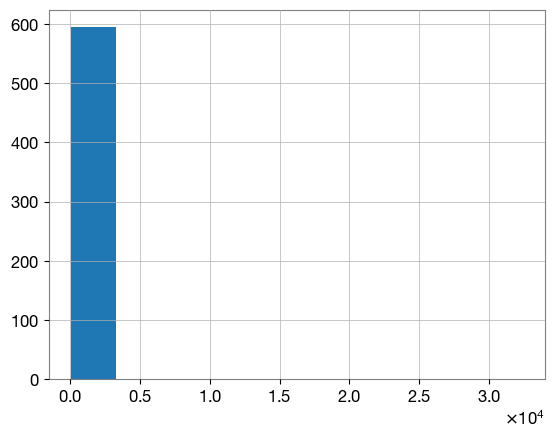

In [29]:
# A very limited view of the inferred tidal deformability (many more EoSs would need to be used for
# an actual analysis)
plt.hist(result["likelihood_evaluations"]["Lambda2"], weights=np.exp(result["likelihood_evaluations"]["logweight"]) )